In [1]:
# always run this cell

import os
import cartopy.crs as ccrs
from dask.distributed import LocalCluster, progress
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import xarray as xr

from src.analysis.load_SAIdata import open_mfdataset, Cases
import src.analysis.tracks as tracks

%matplotlib inline

Exps = {'ref':'Reference', 'cnt':'RCP8.5', 'sai':'SAI2050'} # used in track dataset
exps = {'ref':'Ref.', 'cnt':'Control', 'sai':'SAI'}  # used for plot titles
savefigkwargs = {'dpi':300, 'transparent':True, 'bbox_inches':'tight'}

C:\Users\jsprd\Anaconda3\envs\py313\Lib\site-packages\pyproj\network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


## Computations

In [2]:
experiment = 'ref'
run_ensemble = 6
Exp = Exps[experiment]
stream, stream_prec = ('h1','h2') if (experiment in ('ref','cnt')) and (run_ensemble <= 5) else ('h5','h3')
savefile = f'PRECT_sum.{experiment}.{run_ensemble}.nc'
print(f'{Exp=}, {stream=}, {stream_prec=}, {savefile=}')

Exp='Reference', stream='h5', stream_prec='h3', savefile='PRECT_sum.ref.6.nc'


In [3]:
def read_CAM_prect(experiment, run_ensemble, stream_prec):
    case = Cases(f'hres.{experiment}.{run_ensemble}').select('atm',stream_prec)
    ds_cam = case.open_mfdataset(decode_times=False)
    ds_cam = ds_cam.drop_vars(('date_written','time_written'))
    dt = (ds_cam.time[1] - ds_cam.time[0]).item() # time step (days)
    if 'time: mean' in getattr(ds_cam.PRECT, 'cell_methods', ''):
        ds_cam['time'] = ds_cam['time_bnds'].mean('nbnd', keep_attrs=False).assign_attrs(ds_cam.time.attrs)
    if dt == 0.125:
        print('converting 3hrly avg precipitation to 6hrly')
        ds_cam = ds_cam.coarsen(time=2).mean(keep_attrs=True)
    dt = (ds_cam.time[1] - ds_cam.time[0]).item() # time step (days)
    assert dt == 0.25, f'precipitation should be 6hrly, but {dt=}'
    return ds_cam


def get_timestamps(ds):
    """for each year, create array of timestamps at which TCs are active
    
    ds : xr.Dataset
        track dataset

    returns : 
    track_times : dict(str, arr)
        mapping from year to array of timestamps
    """
    track_times = {}
    for year in np.unique(ds.year):
        if np.isnan(year):
            continue
        dsi = ds.where(ds.year==year, drop=True)
        track_times_i = np.sort(np.unique(dsi.time))
        track_times_i = track_times_i[~np.isnan(track_times_i)]
        track_times[f'{int(year)}'] = track_times_i
        # print(int(year), len(track_times_i)/8) # days with active TCs
    return track_times

# dsi = ds_tracks[Exp].where(ds_tracks[Exp].ens==run_ensemble, drop=True)
# track_times = get_timestamps(dsi)
# track_times


def circular_mask_TC(TC_lon, TC_lat, ds, r=5):
    """create circular mask of r degrees around TC
    using periodic boundary conditions for longitude

    TC_lon, TC_lat : float, float
        longitude and latitude of TC

    ds : xr.Dataset
        should contain lon and lat fields

    r : int | float
        radius of circular mask in degrees

    returns:
    circlemask : bool (ds.lat.size x ds.lon.size)
        true where distance to TC is less than or equal to r
    """
    assert r > 0, 'r must be positive'
    assert r < 30, 'can only handle radii <30degs to prevent issues near the poles'
    dlon = (ds.lon-TC_lon+180)%360 - 180 
    dlat = ds.lat-TC_lat
    circlemask = np.sqrt(dlat**2 + dlon**2) <= r
    return circlemask

# mask = circular_mask_TC(0,25,ds_cam,r=25)
# mask.plot(x='lon')
# plt.grid()


def join_TC_masks(ids, ds_tracks, ds_cam, r=5):
    """create mask field that is true within r degrees of any TC

    ids : array of int (N x 2)
        point coordinates (id x dtime) of (N) TCs

    ds_tracks, ds_cam : xr.Dataset
        track / CAM dataset

    r : int | float
        radius of circular mask around individual TCs

    returns:
    joined_masks : bool (ds_cam.lat.size x ds_cam.lon.size)
        joined circular mask field
        true where distance to any TC is smaller than or equal to r
    """
    masks = [xr.zeros_like(ds_cam.lat * ds_cam.lon, dtype='bool')]
    for (tid,dt) in ids:  # loop through active TCs
        ds_TC = ds_tracks.isel(id=tid, dtime=dt)
        mask = circular_mask_TC(ds_TC.lon, ds_TC.lat, ds_cam, r)
        masks.append(mask)
    masks = xr.concat(masks, dim='n', coords='minimal', compat='override')
    joined_masks = masks.any('n')
    return joined_masks


def interpolate_time(time, da):
    """linearly interpolate da to time step 'time'

    time : float
        time to interpolate to

    da : xr.DataArray
        data to interpolate (must have time coordinate)

    returns:
    da_interp : xr.DataArray
        da interpolated to 'time'
    """
    if time in da.time:
        return da.sel(time=time)
    ax = da.dims.index('time')
    id1 = np.searchsorted(da.time, time)
    id0 = max(id1 - 1, 0)
    da_adj = da.isel(time=slice(id0,id1+1))
    interped = interp1d(da_adj.time, da_adj, axis=ax)(time)
    da_interp = da.isel(time=0)
    da_interp.time.data = time
    da_interp.data = interped
    return da_interp


def main():
    dsi_tracks = ds_tracks[Exp].where(ds_tracks[Exp].ens==run_ensemble, drop=True)  # select tracks for experiment and ensemble
    track_times = get_timestamps(dsi_tracks)
    precip_sum = {}
    dt = 3 * 60 * 60 # time difference (s) between track points
    for (year,timestamps) in track_times.items():  # loop through years
        print(year)
        pcip_sum_year = xr.zeros_like(ds_cam.lat*ds_cam.lon, dtype='float32')
        pcip_sum_year = (pcip_sum_year
                         .rename('PRECT')
                         .assign_coords(year=int(year))
                         .assign_attrs({'name':'PRECT','long_name':'precipitation sum','units':'mm/year'}))
        for time in timestamps[0:80]:  # loop through time stamps with active TCs
            if (time - timestamps[0])%1==0:
                print('\rcurrent day of year:',time-timestamps[0]+1, end=', ')
            PRECT_step = interpolate_time(time, ds_cam.PRECT) # 6hrly average precipitation (m/s)
            ids = np.nonzero(dsi_tracks.time == time).T  # IDs of active TCs at time step
            mask = join_TC_masks(ids, dsi_tracks, ds_cam, r=5) # mask (Nlat x Nlon), true within r degrees of any TC
            dPRECT = mask.astype('int') * PRECT_step * dt * 1000 # precipitation sum (mm) over 3hr interval between track points
            pcip_sum_year += dPRECT.compute()
        print('')
        precip_sum[year] = pcip_sum_year.drop_vars(('time','id','dtime'))
    
    # save results
    ds = xr.concat(precip_sum.values(), dim='year').to_dataset()
    ds.to_netcdf(savefile)
    return 

### TC precipitation computations (testing)

the actual computations are done through precipitation.py

In [7]:
ds_cam = read_CAM_prect(experiment, run_ensemble, stream_prec)
ds_tracks = tracks.load_tracks('../../jobs/Tracking_TC_RV.infext2/', ext='.infext')

Reading combined kerchunk reference file /home/jasperdj/kerchunk/hres_b.e10.B2000_CAM5.f02_t12.started_2002-12_without_SAI.001.cam2.h3.2002-12-01-21600_2007-12-01-21600.json
REF.001: 5.000 years, 470 tracks
REF.002: 5.000 years, 480 tracks
REF.003: 5.000 years, 490 tracks
REF.004: 5.000 years, 493 tracks
REF.005: 5.000 years, 514 tracks
REF.006: 5.000 years, 454 tracks
RCP.001: 5.000 years, 440 tracks
RCP.002: 5.000 years, 439 tracks
RCP.003: 5.000 years, 457 tracks
RCP.004: 5.000 years, 458 tracks
RCP.005: 5.000 years, 451 tracks
RCP.006: 5.000 years, 468 tracks
SAI.001: 5.000 years, 422 tracks
SAI.002: 5.000 years, 436 tracks
SAI.003: 5.000 years, 407 tracks
SAI.004: 5.000 years, 428 tracks
SAI.005: 5.000 years, 409 tracks
SAI.006: 5.000 years, 413 tracks


In [8]:
%%time
main()

2003
current day of year: 10.0, 
2004
current day of year: 10.0, 
2005
current day of year: 11.0, 
2006
current day of year: 15.0, 
2007
current day of year: 10.0, 
CPU times: user 22.1 s, sys: 3.57 s, total: 25.7 s
Wall time: 25 s


read the computation results from the batch job (PRECT_sum.exp.ens.nc), where exp is \[ref, cnt, sai] and ens \[1,2,3,4,5,6]  
merge and average into one dataset: PRECT_sum_TC.nc  
then delete original datasets

In [4]:
def open_TC_prect_mfdataset(exp):
    ds = xr.open_mfdataset(f'PRECT_sum.{exp}.?.nc', combine='nested', concat_dim='ens')
    ds = ds.stack(x=('ens','year'), create_index=False).assign_coords(exp=exp)
    ds['PRECTstd'] = ds.PRECT.std('x', ddof=1).assign_attrs({
        'long_name':'interannual standard deviation of TC precipitation',
        'units':ds.PRECT.units})
    ds['N'] = ds.x.size
    ds.N.attrs = {'long_name':'number of years used for mean and std'}
    ds['PRECT'] = ds.PRECT.mean('x', keep_attrs=True)
    ds = ds.drop_vars(('ens','year'))
    return ds

ds = xr.concat([open_TC_prect_mfdataset(exp) for exp in exps], dim='exp')
ds.attrs['description'] = 'interannual mean and standard deviation of annual rainfall sum due to TCs'

In [5]:
ds

<xarray.Dataset> Size: 21MB
Dimensions:   (exp: 3, lat: 768, lon: 1152)
Coordinates:
  * lat       (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon       (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
  * exp       (exp) <U3 36B 'ref' 'cnt' 'sai'
Data variables:
    PRECT     (exp, lat, lon) float32 11MB dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    PRECTstd  (exp, lat, lon) float32 11MB dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    N         (exp) int64 24B 30 30 30
Attributes:
    description:  interannual mean and standard deviation of annual rainfall ...

In [6]:
ds.to_netcdf('PRECT_sum_TC.nc')

In [16]:
# ## DELETE FILES ##
# for exp in exps:
#     for ens in range(1,7):
#         os.remove(f'PRECT_sum.{exp}.{ens}.nc')

### annual total rainfall computations

In [18]:
def annual_mean_total_precipitation(experiment, run_ensemble):
    stream_prec = 'h2' if (experiment in ('ref','cnt')) and (run_ensemble <= 5) else 'h3'
    years = range(2003,2008) if experiment=='ref' else range(2093,2098)
    case = Cases(f'hres.{experiment}.{run_ensemble}').select('atm',stream_prec)
    ds_cam = case.open_mfdataset(decode_times=True)
    prect = [(ds_cam.PRECT.sel(time=str(year)).mean('time', keep_attrs=True)
              .assign_coords(year=year, ens=run_ensemble, exp=experiment)) for year in years]
    prect = xr.concat(prect, dim='year')
    return prect

Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.002.cam2.h2.2092-12-01-10800_2098-01-05-10800.json


(array(2), array('cnt', dtype='<U3'))

In [ ]:
cluster = LocalCluster(n_workers=18)

In [21]:
client = cluster.get_client()

In [28]:
prect_mean = xr.concat([
    xr.concat([
        annual_mean_total_precipitation(exp, ens) for ens in range(1,7)
    ], dim='ens') for exp in exps
], dim='exp')

Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001.cam2.h2.2002-12-01-10800_2012-12-31-10800.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.002.cam2.h2.2002-12-01-10800_2007-12-31-10800.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.003.cam2.h2.2002-12-01-10800_2007-12-31-10800.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.004.cam2.h2.2002-12-01-10800_2007-12-31-10800.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.005.cam2.h2.2002-12-01-10800_2008-02-24-10800.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/hres_b.e10.B2000_CAM5.f02_t12.started_2002-12_without_SAI.001.cam2.h3.2002-12-01-21600_2007-12-01-21600.json
Readin

In [ ]:
prect_mean = prect_mean.persist()

In [33]:
progress(prect_mean)

VBox()

In [69]:
%%time
years_used = [30,30,30] # number of years used for averaging [ref,cnt,sai]

prect_mean_x = prect_mean.stack(x=('ens','year'))
ds_prect_mean = xr.Dataset({
    'PRECT': prect_mean_x.mean('x', keep_attrs=True),
    'PRECTstd': (prect_mean_x.std('x', ddof=1).assign_attrs({
        'long_name':'interannual standard deviation of precipitation',
        'units':prect_mean.units})),
    'N': ('exp', years_used, {'long_name':'total number of years used'})
}, coords = prect_mean_x.mean('x').coords,)
ds_prect_mean.to_netcdf('PRECT_sum.nc')

CPU times: user 47.4 s, sys: 633 ms, total: 48 s
Wall time: 42.6 s


In [70]:
client.shutdown()

In [71]:
cluster.close()

## Plotting

In [2]:
ds_tc = xr.open_dataset('PRECT_sum_TC.nc')
ds_cam = xr.open_dataset('PRECT_sum.nc')

In [3]:
#os.mkdir('fig')

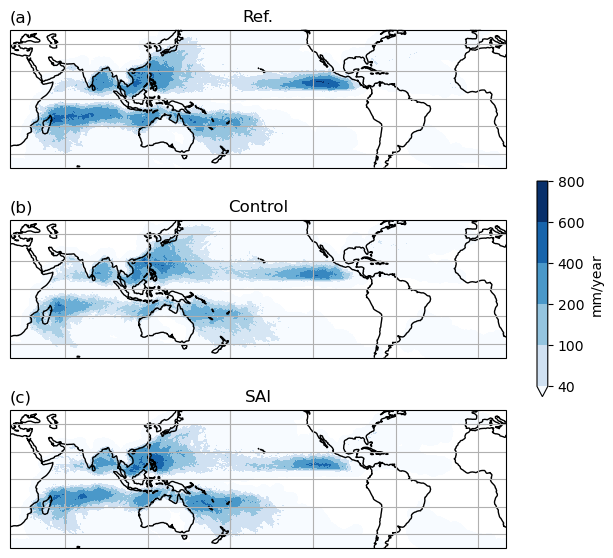

In [4]:
## Annual TC precipitation

fig = plt.figure(figsize=(8,7))

for e,exp in enumerate(exps):
    ax = fig.add_subplot(3,1,e+1,projection=ccrs.PlateCarree(central_longitude=200))
    C = ds_tc.PRECT.sel(exp=exp)
    cs = C.where(C>0,np.nan).plot(ax=ax, transform=ccrs.PlateCarree(), rasterized=True,
        levels=[40,100, 200, 400, 600, 800], cmap='Blues', add_colorbar=False)
    ax.coastlines()
    ax.gridlines()
    ax.set_extent((-180,180,-50,50), crs=ccrs.PlateCarree())
    ax.set_title(exps[exp])
    ax.set_title(['(a)','(b)','(c)'][e], loc='left')
fig.colorbar(cs, ax=fig.axes, shrink=0.4, label='mm/year')
fig.savefig('fig/PRECT_TC_annual_sum.pdf', **savefigkwargs)

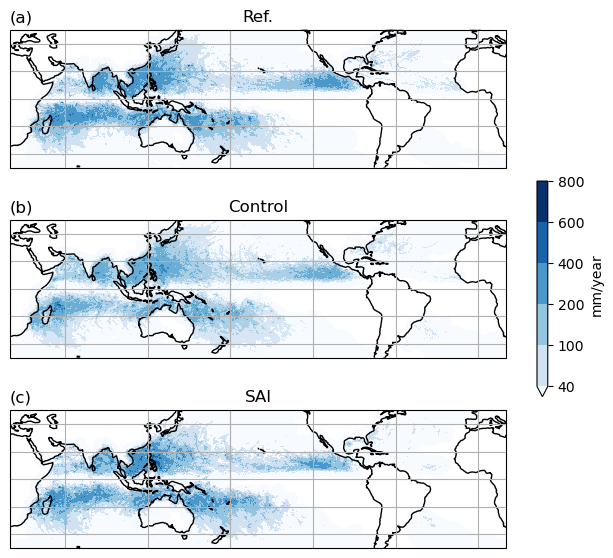

In [5]:
## interannual standard deviation of TC precipitation sum

fig = plt.figure(figsize=(8,7))

for e,exp in enumerate(exps):
    ax = fig.add_subplot(3,1,e+1,projection=ccrs.PlateCarree(central_longitude=200))
    C = ds_tc.PRECTstd.sel(exp=exp)
    cs = C.where(C>0,np.nan).plot(ax=ax, transform=ccrs.PlateCarree(), rasterized=True,
        levels=[40,100, 200, 400, 600, 800], cmap='Blues', add_colorbar=False)
    ax.coastlines()
    ax.gridlines()
    ax.set_extent((-180,180,-50,50), crs=ccrs.PlateCarree())
    ax.set_title(exps[exp])
    ax.set_title(['(a)','(b)','(c)'][e], loc='left')
fig.colorbar(cs, ax=fig.axes, shrink=0.4, label='mm/year')
fig.savefig('fig/PRECT_TC_annual_sum_std.pdf', **savefigkwargs)

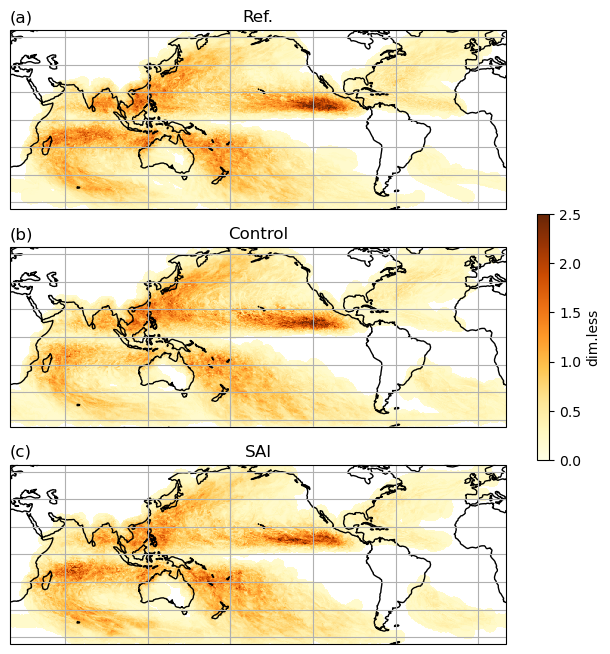

In [6]:
## interannual mean / interannual standard deviation of TC precipitation sum

fig = plt.figure(figsize=(8,8))

for e,exp in enumerate(exps):
    ax = fig.add_subplot(3,1,e+1,projection=ccrs.PlateCarree(central_longitude=200))
    C = ds_tc.PRECT.sel(exp=exp) / ds_tc.PRECTstd.sel(exp=exp)
    cs = C.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=2.5, cmap='YlOrBr', 
                rasterized=True, add_colorbar=False)
    ax.coastlines()
    ax.gridlines()
    ax.set_extent((-180,180,-65,65), crs=ccrs.PlateCarree())
    ax.set_title(exps[exp])
    ax.set_title(['(a)','(b)','(c)'][e], loc='left')
fig.colorbar(cs, ax=fig.axes, shrink=0.4, label='dim.less')
fig.savefig('fig/PRECT_TC_annual_sum_std_frac.pdf', **savefigkwargs)

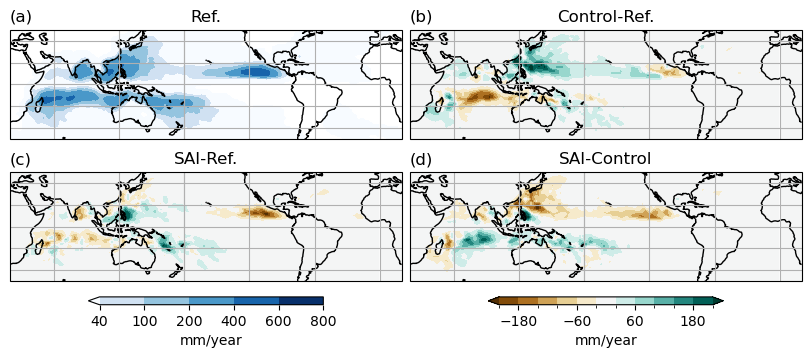

In [8]:
## Annual TC precipitation change (downscaled to 2 deg resolution)

ds_tc_lr = ds_tc.coarsen(lat=8, lon=8).mean()

fig,axs = plt.subplots(2,2,figsize=(8,3.5),subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)}, layout='constrained')
axsf = axs.flat

ax = axsf[0]
exp = 'ref'
C = ds_tc_lr.PRECT.sel(exp=exp)
cs1 = C.where(C>0,np.nan).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=[40,100, 200, 400, 600, 800], cmap='Blues', add_colorbar=False)
ax.set_title(exps[exp])
ax.set_title('(a)', loc='left')

ax = axsf[1]
exp1 = 'ref'
exp2 = 'cnt'
C = ds_tc_lr.PRECT.sel(exp=exp2) - ds_tc_lr.PRECT.sel(exp=exp1)
cs = C.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=np.arange(-220,221,40), cmap='BrBG', add_colorbar=False)
ax.set_title(f'{exps[exp2]}-{exps[exp1]}')
ax.set_title('(b)', loc='left')

ax = axsf[2]
exp1 = 'ref'
exp2 = 'sai'
C = ds_tc_lr.PRECT.sel(exp=exp2) - ds_tc_lr.PRECT.sel(exp=exp1)
cs = C.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=np.arange(-220,221,40), cmap='BrBG', add_colorbar=False)
ax.set_title(f'{exps[exp2]}-{exps[exp1]}')
ax.set_title('(c)', loc='left')

ax = axsf[3]
exp1 = 'cnt'
exp2 = 'sai'
C = ds_tc_lr.PRECT.sel(exp=exp2) - ds_tc_lr.PRECT.sel(exp=exp1)
cs = C.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=np.arange(-220,221,40), cmap='BrBG', add_colorbar=False)
ax.set_title(f'{exps[exp2]}-{exps[exp1]}')
ax.set_title('(d)', loc='left')

[-180,-100,-20,20,100,180]
cb2 = fig.colorbar(cs, ax=axs[:,1], label='mm/year', shrink=0.6, aspect=30, ticks=[-180,-60,60,180], orientation='horizontal') # dif plots
cb1 = fig.colorbar( cs1, ax=axs[:,0], label='mm/year', shrink=0.6, aspect=30, orientation='horizontal') # ref.

for a,ax in enumerate(axsf):
    ax.coastlines()
    ax.gridlines()
    ax.set_extent((-180,180,-50,50), crs=ccrs.PlateCarree())

#fig.savefig('fig/PRECT_TC_annual_sum_change.pdf', **savefigkwargs)  # without coarsening
fig.savefig('fig/PRECT_TC_annual_sum_change_2deg.pdf', **savefigkwargs)

In [9]:
Fprec = 365 * 24 * 3600 * 1000 # m/s to mm/year 

In [10]:
print('maximum annual precipitation:')
for exp in exps:
    print(f'{exp}: {ds_cam.PRECT.sel(exp=exp).max().data*Fprec:.1f} mm/year')

maximum annual precipitation:
ref: 25509.4 mm/year
cnt: 28976.8 mm/year
sai: 24790.9 mm/year


CPU times: total: 15.2 s
Wall time: 16.5 s


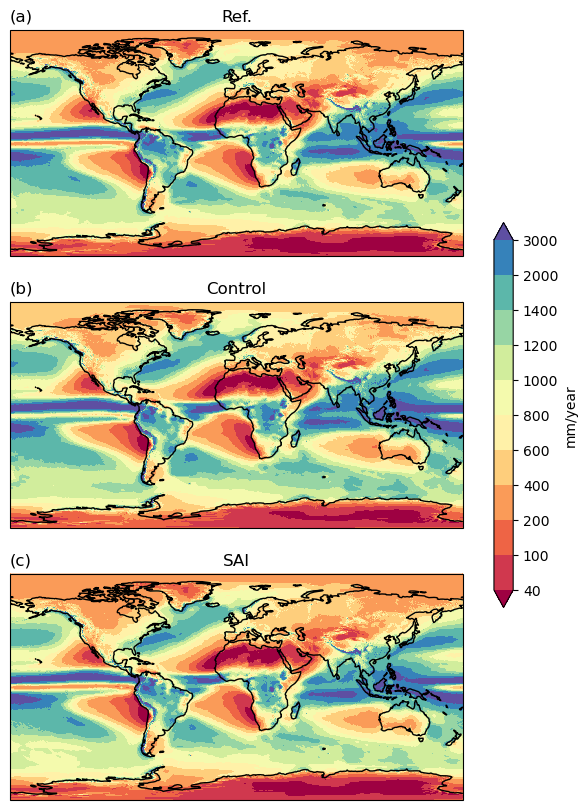

In [11]:
%%time

## total annual rainfall

proj = ccrs.PlateCarree(central_longitude=200)
proj = ccrs.PlateCarree()
crs = ccrs.PlateCarree()

# annual rainfall sum
fig = plt.figure(figsize=(8,10))
clevels = [40,100, 200, 400, 600, 800, 1000, 1200,1400,2000,3000]

for e,exp in enumerate(exps):
    ax = fig.add_subplot(3,1,e+1,projection=proj)
    C = ds_cam.PRECT.sel(exp=exp) * Fprec
#     cs = ax.contourf(C.lon, C.lat, C, levels=[40,100, 200, 400, 600, 800, 1000, 1200,1400,2000,3000], 
#            transform=crs, cmap='RdBu')
    cs = C.plot(ax=ax, levels=clevels, 
           transform=crs, cmap='Spectral', add_colorbar=False, x='lon', rasterized=True)   
    ax.coastlines()
    ax.set_title(exps[exp])
    ax.set_title(['(a)','(b)','(c)'][e], loc='left')
fig.colorbar(cs, ax=fig.axes, shrink=0.5, ticks=clevels, label='mm/year')
fig.savefig('fig/PRECT_annual_sum.pdf', **savefigkwargs)

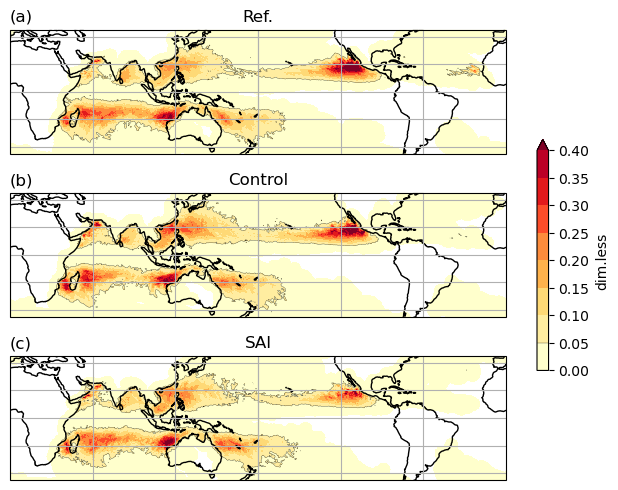

In [12]:
## TC precipitation fraction of total annual precipitation

fig = plt.figure(figsize=(8,6))
for e,exp in enumerate(exps):
    ax = fig.add_subplot(3,1,e+1,projection=ccrs.PlateCarree(central_longitude=180))
    Z = ds_tc.PRECT.sel(exp=exp)/(ds_cam.PRECT.sel(exp=exp) * Fprec)
    cs = Z.where(Z>0,np.nan).plot(ax=ax, levels=np.arange(0,0.41,0.05), transform=ccrs.PlateCarree(), rasterized=True, cmap='YlOrRd', add_colorbar=False)
    Z.plot.contour(ax=ax, levels=[0.05], linewidths=0.2, colors='k', transform=ccrs.PlateCarree())
    #pcip_sum_total.plot.contour(levels=[500,3500], colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), linestyles=['--','-'])
    ax.coastlines()
    ax.gridlines()
    #ax.set_extent((90,160,-40,40), crs=ccrs.PlateCarree())
    ax.set_extent((-180,180,-45,45), crs=ccrs.PlateCarree())
    ax.set_title(exps[exp])
    ax.set_title(['(a)','(b)','(c)'][e], loc='left')
cbar = fig.colorbar(cs, ax=fig.axes, shrink=0.5, label='dim.less')
cbar.ax.axhline(0.05,lw=0.2,c='k')
fig.savefig('fig/PRECT_TC_annual_sum_frac.pdf', **savefigkwargs)

In [13]:
ds_tc.close()
ds_cam.close()